In [1]:
# just execute this cell to have the proper functions imported
# the cell must run correctly to be able to run the assignement
#
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as si
answers = {}

# One Period Binomial Model

God speaks to you in a dream and tells you that a stock will be worth either 105 or 92 in 6 month. 

You wake up and decide to arb the option market. First, you compute the hedge ratio for an option with a strike of 100...



In [5]:
# Edit the line as instructed for proper answer in this cell
#
Su,Sd,K= 105, 92, 100
Vu,Vd = max(Su-K,0), max(Sd-K,0)
hedgeratio = ( Vu - Vd )/( Su - Sd ) # <----- edit this line to put the proper hedge ratio
print("Hedge ratio is %f" % hedgeratio)
answers["one period model hedge ratio is"] = hedgeratio

Hedge ratio is 0.384615


### Pricing the option and checking price is right

You check the market, the spot price is 100, and you can borrow at 5.5%

- you check that the value of the porfolio $P_T = V_T - h S_T$ is the same in up and down state. It is risk free w.r. to moves of the underlying $S$
- you check the discounted expected value $P_0 = e^{-rT} P_T$ of the replcating portfolio
- you compute the probability and expected value of the payoff


In [11]:
# Edit the lines as instructed for proper answer in this cell
#
S, r, T = 100, 0.055, 0.5

Pu = Vu - hedgeratio * Su
Pd = Vd - hedgeratio * Sd # <--- edit this line to make sure the computation is correct
answers["the value of replicating portfolio Pd is"] = Pd
print("replicating portfolio forward value: Pu=%f, Pd=%f" % (Pu,Pd))
P = Pu * np.exp(-r * T)

V = P + hedgeratio * S
print("no arb call from portfolio replication=%f" % (V))
F = S*np.exp(r*T)

p = (F-Sd)/(Su-Sd)  # <-- edit this line to make sure the calculation is correct
answers["the value of risk neutral p is"] = p

call = np.exp( -r * T ) * ( p * Vu + ( 1 - p ) * Vd )
print("Pr(up)=%f, Pr(down)=%f, call from risk neutral expectation=%f" % (p,1-p,call))

replicating portfolio forward value: Pu=-35.384615, Pd=-35.384615
no arb call from portfolio replication=4.036742
Pr(up)=0.829859, Pr(down)=0.170141, call from risk neutral expectation=4.036742


### Check Against Black Scholes formula: 

The function below computes $c=E(e^{-rT}\max(S_T-K,0)$ $p=E(e^{-rT}\max(K-S_T,0)$ 

Under the usual Black Scholes Model assumptions that the equity price $S$ follow the diffusion $$\frac{dS}{S} = rdt + \sigma dW_t$$

If a reasonnable value of volatility is 15%, you want to check the call price under this assumption


In [13]:
# Edit the line as instructed for proper answer in this cell
#

def black_scholes_premium(S, K, T, r, sigma):
    df = np.exp(-r * T) 
    if T<1e-8 or sigma<1e-8:
        call = max(S-K*df, 0.)
        vega = 0
    else:
        sqt = np.sqrt(T)
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqt)
        d2 = d1 - sigma * sqt
        call = S * si.norm.cdf(d1, 0.0, 1.0) - K * si.norm.cdf(d2, 0.0, 1.0) * df
        #vega = S * si.norm.pdf(d1, 0.0, 1.0) * sqt 
        delta = si.norm.cdf(d1, 0.0, 1.0)
    put  =  call + K*df-S # use call-put parity for the put
    return call, put, delta

sigma = 0.15
callbsm,_,deltabsm = black_scholes_premium(S, K, T, r, sigma)
print("black-scholes model call=%f" % callbsm)
#
# The binomial two states Su=105 Sd=92 look wide or narrow compared to BSM with 15% volatility?
answers["answer either wide or narrow"] = "narrow" # <--- edit this line to answer either "wide" or "narrow"

black-scholes model call=5.667649


## Implicit Binomial Model

We can ask another question:

Given an option price we observe on the market, what can be a binomial model implied by it?

The call price in the binomial model was given by:
$$c = e^{-rT} (p V_u + (1-p) V_d)$$
For an ATM call, the down state will be below strike, and the up state will be positive $V_d = 0, V_u = Su-K$ we have:
$$c = e^{-rT} p (Su-K)$$
Here, we must make an assumption on the relation between $u$ and $d$. We use $d=1/u$, therefore we have $p = \frac{e^{rt}-d}{u-d}=\frac{ue^{rt}-1}{u^2-1}$:
$$e^{rT} c (u^2-1) = (u e^{rt}-1) (Su-K)$$
which looks like a quadratic polynomial equation in $u$:
$$e^{rT} (c-S) u^2 + (S+Ke^{rT}) u - K - e^{rT} c = 0 $$
If the one period model is already giving a quadratic equation, imagine the $n$ period model.

In [14]:
# Edit the line as instructed for proper answer in this cell
#
a = np.exp(r*T)*(callbsm-S)
b = S+K*np.exp(r*T)
c = -K-callbsm*np.exp(r*T)
Delta = b**2-4*a*c
u = (-b-np.sqrt(Delta))/(2*a) # quadratic equation solution such that u>1

p = (u*np.exp(r*T)-1)/(u**2-1) # risk neutral probability up
d = 1/u # assumed down movement
print("check BSM call=%f, binomial=%f" % (callbsm,np.exp(-r*T)*p*(S*u-K)))
print("the values consistent with BSM are Su=%f, Sd=%f p=%f" % (S*u,S*d,p))
answers["does this calculation confirm the intuitive answer of wide or narrows above"] = "yes" # <-- answer yes or no

check BSM call=5.667649, binomial=5.667649
the values consistent with BSM are Su=109.140836, Sd=91.624733 p=0.637324


### Black-Scholes Model vs 1 period Binomial model Risk

In the above cell, we fitted a binomial model to the price given by a Black-Scholes formula.

How does the hedge ratio given by binomial model and black-scholes delta differ?

In [15]:
# Edit the line as instructed for proper answer in this cell
#
fittedbinomialhedgeratio = (max(S*u-K,0)-max(S*d-K,0))/(S*(u-d))
print("hedge ratio implicit with fitted binomial model=%f, BSM delta=%f" % (fittedbinomialhedgeratio,deltabsm))
answers["BSM and binomial model give different risk when fitted to same price"] = "yes" # <--- answer yes or no

hedge ratio implicit with fitted binomial model=0.521853, BSM delta=0.622596


# Multi Period Binomial Tree Pricer

These trees are usually coded in a faster language than python. 

- The binomial tree below takes the payoff as function parameter
- The code supports european and american options, looks at what the code does if american


binomial tree with european put payoff=max(K-S)


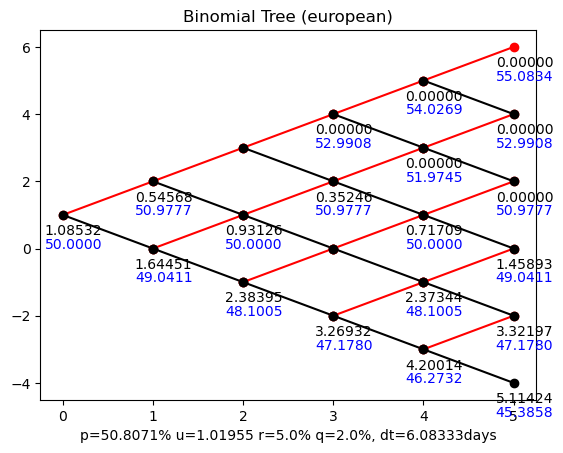

In [17]:
# Edit the lines below as instructed for proper answer in this cell
#
# ---------------------------------------------------------------------------
# binomial_tree_pricer
# parameters:
# r: risk neutral rate
# q: dividend yield
# sigma: volatility
# T: maturity in years
# n: number of time steps
# S: spot stock price
# payoff: payoff function e.g.: lambda S: max(S-K,0)
# american: early exercise: True if american, otherwise European
# showStatePrices: print tree probabilities and state prices
def binomial_tree_pricer(r,q,sigma,T,n,S,payoff,american=True,showStatePrices=False):
    dt = T/n
    up  = np.exp(sigma*np.sqrt(dt))
    p0 = (up * np.exp((r-q) * dt) - 1) / (up**2 - 1) 
    p1 = 1 - p0
    df = np.exp(-r * dt)
    # initial values at time T
    statePrices = {"p":p0,"u":up,"r":r,"q":q,"dt":dt}
    if showStatePrices:
        statePrices["option"] = "american" if american else "european"
        statePrices["payoff"]=np.zeros((n+1,n+1))
        statePrices["underlying"]=np.zeros((n+1,n+1))
    p = np.zeros(n+1)
    for i in range(n+1): # i from 0 to n incl
        p[i] = payoff(S * up**(2*i - n))
        if showStatePrices:
            statePrices["payoff"][n][i] = p[i]
            statePrices["underlying"][n][i] = S * up**(2*i - n)
    # move to earlier times
    for j in range(n-1,-1,-1): # j from n-1 to 0 incl
        for i in range(j+1): # i from 0 to j incl
            # discounted expected value of exdiv price
            p[i] = (p0 * p[i+1] + p1 * p[i])*df
            # american payoff
            if american:
                early_exercise = payoff(S * up**(2*i - j))
                p[i] = max(early_exercise,p[i])
            if showStatePrices:
                statePrices["payoff"][j][i] = p[i]
                statePrices["underlying"][j][i] = S * up**(2*i - j)
    if showStatePrices:
        plot_binomial_tree(statePrices)
    return p[0]
def plot_binomial_tree(statePrices):
    for i in range(0,n+1):
        for j in range(0,n+1):
            if j>i:
                break
            if i<n:
                x1, y1 = [i, i+1], [2*j-(i-1),2*j+1-(i-1)]
                plt.plot(x1, y1, marker = 'o',color="red")
                x1, y1 = [i, i+1], [2*j-(i-1),2*j-1-(i-1)]
                plt.plot(x1, y1, marker = 'o',color="black")
            if (i==2 and j==2) or (i==3 and j==1):
                continue
            plt.text(i-0.2,2*j-(i-1)-0.6,"%.5f" % statePrices["payoff"][i][j])
            plt.text(i-0.2,2*j-(i-1)-1.0,"%.4f" % statePrices["underlying"][i][j],color="blue")
    plt.title("Binomial Tree (%s)" % statePrices["option"])
    plt.xlabel("p=%.4f%% u=%.5f r=%.1f%% q=%.1f%%, dt=%.5fdays" % (statePrices["p"]*100,
                                                                   statePrices["u"],
                                                                   statePrices["r"]*100,
                                                                   statePrices["q"]*100,
                                                                   statePrices["dt"]*365))
    #plt.savefig("binomial_missing.jpg")
    #plt.close()
    plt.show()
r,q,sigma,T,n,S = 0.05, 0.02, 0.15, 1/12, 5, 50
K = S*1.01
print("binomial tree with european put payoff=max(K-S)")
option = binomial_tree_pricer(r,q,sigma,T,n,S,lambda S: max(K-S,0),american=False,showStatePrices=True)
answers["the underlying price is shown in"] = "blue" # <-- answer either "black" or "blue"
answers["the european put value at time step 2 in the all up scenario is"] = 0 # <-- read the value from diagram below
answers["the european put value at time step 2 in the all down scenario is"] = 2.38395 # <-- read the value from diagram below


### American Option Pricing

Look again at what the code does when american is set to True.

The value of the option at any date $t \in [0,T]$ is taken as the max of:
- an exercise value at S-K at $t$
- a continuation value where we keep the option for future times $u, t<u<T$

Pricing is done backward from $t=T$ and computing discounting expected value back to $t=0$


In [ ]:
# Edit the lines below as instructed for proper answer in this cell
#
print("binomial tree with american put payoff=max(K-S)")
binomial_tree_pricer(r,q,sigma,T,n,S,lambda S: max(K-S,0),american=True,showStatePrices=True)
answers["the american put value at time step 2 in the all up scenario is"] = 0 # <-- read the value from diagram below
answers["the american put value at time step 2 in the all down scenario is"] = 2.41632 # <-- read the value from diagram below
n = 300

binomial tree with american put payoff=max(K-S)


### Numerical convergence 

The fist thing to assess is the numerical convergence of the binomial tree pricer towards the black-scholes formula as $n \rightarrow \infty, \Delta t \rightarrow 0$.

Your manager asks you to chose a number of steps $n$, what do you chose?

In [ ]:
# Edit the line below as instructed for proper answer in this cell
#
import datetime as dt
call,put,_ = black_scholes_premium(S*np.exp(-q*T), K, T, r, sigma)
nbs = [1,2,3,4,5,10,50,75,100,200,500,1000,2000]
err,elapsed = {},{}
for n in nbs:
    ts = dt.datetime.now()
    err[n] = np.log10(np.abs((call-binomial_tree_pricer(r,q,sigma,T,n,S,lambda S: max(S-K,0),american=False))/K))
    elapsed[n] = np.log10((dt.datetime.now()-ts).total_seconds())
n = 300
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.plot(elapsed.values(),label="elapsed",color="orange")
ax2.set_ylabel("log10 seconds elapsed")
ax1.plot(err.values(),label="error relative to spot")
ax1.axhline(y=np.log10(call/S),color="red",label="option price")
ax1.set_xlabel("nb of time steps")
ax1.set_ylabel("log10 relative error")
ax = plt.gca()
ax.set(xticks=range(len(nbs)), xticklabels=nbs)
ax1.legend(loc="upper left")
ax2.legend(loc="lower left")
plt.title("Binomial Tree Convergence")
plt.show()
answers["what value of n do you recommend"] = np.nan # <-- enter the value you recommend

### Comparing calls and puts when there is a dividend yield

we now compare european and american option prices

In [ ]:
# Edit the line below as instructed for proper answer in this cell
#
print("risk neutral r=%f dividend yield q=%f" % (r,q))
call,put,_ = black_scholes_premium(S*np.exp(-q*T), K, T, r, sigma)
print("black-scholes formula call=%f put=%f" % (call,put))
print("european call binomial=%f"%binomial_tree_pricer(r,q,sigma,T,n,S,lambda S: max(S-K,0),american=False))
print("american call binomial=%f"%binomial_tree_pricer(r,q,sigma,T,n,S,lambda S: max(S-K,0),american=True))
print("european put binomial=%f"%binomial_tree_pricer(r,q,sigma,T,n,S,lambda S: max(K-S,0),american=False))
print("american put binomial=%f"%binomial_tree_pricer(r,q,sigma,T,n,S,lambda S: max(K-S,0),american=True))
answers["american calls have higher, lower or same value as european for r>0,q>0"] = ""  # <--- answer higher, lower or same
answers["american puts have higher, lower or same value as european for r>0,q>0"] = ""  # <--- answer higher, lower or same

In [ ]:
# Edit the line below as instructed for proper answer in this cell
#
q = 0.00
print("risk neutral r=%f dividend yield q=%f" % (r,q))
call,put,_ = black_scholes_premium(S*np.exp(-q*T), K, T, r, sigma)
print("black-scholes formula call=%f put=%f" % (call,put))
print("european call binomial=%f"%binomial_tree_pricer(r,q,sigma,T,n,S,lambda S: max(S-K,0),american=False))
print("american call binomial=%f"%binomial_tree_pricer(r,q,sigma,T,n,S,lambda S: max(S-K,0),american=True))
print("european put binomial=%f"%binomial_tree_pricer(r,q,sigma,T,n,S,lambda S: max(K-S,0),american=False))
print("american put binomial=%f"%binomial_tree_pricer(r,q,sigma,T,n,S,lambda S: max(K-S,0),american=True))
answers["american calls have higher, lower or same value as european for r>0,q=0"] = ""  # <--- answer higher, lower or same
answers["american puts have higher, lower or same value as european for r>0,q=0"] = ""  # <--- answer higher, lower or same

In [ ]:
# Edit the line below as instructed for proper answer in this cell
#
r = 0.00
print("risk neutral r=%f dividend yield q=%f" % (r,q))
call,put,_ = black_scholes_premium(S*np.exp(-q*T), K, T, r, sigma)
print("black-scholes formula call=%f put=%f" % (call,put))
print("european call binomial=%f"%binomial_tree_pricer(r,q,sigma,T,n,S,lambda S: max(S-K,0),american=False))
print("american call binomial=%f"%binomial_tree_pricer(r,q,sigma,T,n,S,lambda S: max(S-K,0),american=True))
print("european put binomial=%f"%binomial_tree_pricer(r,q,sigma,T,n,S,lambda S: max(K-S,0),american=False))
print("american put binomial=%f"%binomial_tree_pricer(r,q,sigma,T,n,S,lambda S: max(K-S,0),american=True))
answers["american calls have higher, lower or same value as european for r=0,q=0"] = ""  # <--- answer higher, lower or same
answers["american puts have higher, lower or same value as european for r=0,q=0"] = ""  # <--- answer higher, lower or same

# Discrete Dividends

In [ ]:
# run this cell, no need to edit it
#
# ---------------------------------------------------------------------------
# binomial_tree_pricer
# parameters:
# r: risk neutral rate
# div: dictionary div[t] = amount <-- where t is the time to exdiv date in years
# sigma: volatility
# T: maturity in years
# n: number of time steps
# S: spot stock price
# payoff: payoff function e.g.: lambda S: max(S-K,0)
# american: early exercise: True if american, otherwise European
# showArrowDebreu: print tree probabilities and state prices
def binomial_tree_divpricer(r,div,sigma,T,n,S,payoff,american=True,showStatePrices=False):
    dt = T/n
    sumdiv, dividx = 0, {}
    for t,amt in div.items():
        if t<=T:
            dividx[int(round(t/dt))] = amt
            sumdiv += amt
        else:
            print("WARN: div input is %f but expiry is %f" % (t,T))
    up  = np.exp(sigma*np.sqrt(dt))
    p0 = (up * np.exp(r*dt) - 1) / (up**2 - 1) 
    p1 = 1 - p0
    df = np.exp(-r * dt)
    # initial values at time T
    statePrices = {"p":p0,"u":up,"r":r,"q":q,"dt":dt}
    if showStatePrices:
        statePrices["option"] = "american" if american else "european"
        statePrices["payoff"]=np.zeros((n+1,n+1))
        statePrices["underlying"]=np.zeros((n+1,n+1))
    p = np.zeros(n+1)
    for i in range(n+1): # i from 0 to n incl
        p[i] = payoff(S * up**(2*i - n) - sumdiv)
        if showStatePrices:
            statePrices["payoff"][n][i] = p[i]
            statePrices["underlying"][n][i] = S * up**(2*i - n) - sumdiv
    # move to earlier times
    for j in range(n-1,-1,-1): # j from n-1 to 0 incl
        if j in dividx.keys():
            sumdiv -= dividx[j]
        for i in range(j+1): # i from 0 to j incl
            # discounted expected value of exdiv price
            p[i] = (p0 * p[i+1] + p1 * p[i])*df
            # american payoff
            if american:
                early_exercise = payoff(S * up**(2*i - j) - sumdiv)
                p[i] = max(early_exercise,p[i])
            if showStatePrices:
                statePrices["payoff"][j][i] = p[i]
                statePrices["underlying"][j][i] = S * up**(2*i - j)- sumdiv
    if showStatePrices:
        plot_binomial_tree(statePrices)
    return p[0]


### Impact of discrete dividends on early exercise for calls and puts

In [ ]:
# Edit the lines below as instructed for proper answer in this cell
#
# impact of discrete dividend on call and put price
r = 0.05
sigma = 0.15
T = 1/2
n = 500
S = 50
K = S*1.01
div = {T/2: S*0.12}
discdiv = np.sum([a for t,a in div.items()])
call,put,_ = black_scholes_premium(S, K+discdiv, T, r, sigma)
callbe = binomial_tree_divpricer(r,div,sigma,T,n,S,lambda S:max(S-K,0),american=False)
callba = binomial_tree_divpricer(r,div,sigma,T,n,S,lambda S:max(S-K,0),american=True)
putbe = binomial_tree_divpricer(r,div,sigma,T,n,S,lambda S:max(K-S,0),american=False)
putba = binomial_tree_divpricer(r,div,sigma,T,n,S,lambda S:max(K-S,0),american=True)
print("c=%.3f p=%.3f black formula"%(call,put))
print("c=%.3f p=%.3f binomial european"%(callbe,putbe))
print("c=%.3f p=%.3f binomial american"%(callba,putba))
answers["american calls have higher, lower or same value as european for discrete div"] = ""  # <--- answer higher, lower or same
answers["american puts have higher, lower or same value as european for discrete div"] = ""  # <--- answer higher, lower or same

### Deep dive in the tree with discrete dividends

In [ ]:
# Edit the lines below as instructed for proper answer in this cell
#
n = 5
binomial_tree_divpricer(r,div,sigma,T,n,S,lambda S:max(S-K,0),american=False,showStatePrices=True)
answers["underlying value is shown in"] = "" # <-- answer either black or blue
answers["underlying value drops by the dividend amount at period"] = np.nan # <-- enter a number between 1 and 5

### Why american calls have more value with discrete dividends

In [ ]:
# Edit the lines below as instructed for proper answer in this cell
#
binomial_tree_divpricer(r,div,sigma,T,n,S,lambda S:max(S-K,0),american=True,showStatePrices=True)
answers["underlying values are same or higher for american than european payoff"] = "" # <-- answer either same or higher
answers["option value is higher for american payoff up to step"] = np.nan # <-- enter a number between 0 and 5
answers["the difference in price comes from up/down moves before/after dividend"] = "" # <-- "up/before" or "up/after" or "down/before" or "down/after"


In [ ]:
# import hashlib,json
# questionhash = {}
# for q in answers.keys():
#     questionhash[q] = hashlib.sha256(("saltmfit5014"+q).encode()).hexdigest()
# json.dumps(questionhash)
#
# you need to edit this cell to edit MYID and MYKEY. running this cell will submit your answers
#
# uncomment line below when ready to post the answer, http status_code for succesful submission is 200
MYID  = 'xxx@ust.hk'
MYKEY ='yyyy'
import requests,json
def post_answer(question, answer):
    questionhash = {"one period model hedge ratio is": "e8c1712915edb888869fe0b5891544b188149c5bc1f0a3b3f19ba281357bcab1", "the value of replicating portfolio Pd is": "a4cfe4ba9abdbd8303659f267716737a7509f95e800b9be59f0d45eaac816633", "the value of risk neutral p is": "140866392434f7c050381ad01ecf053e0eb3ef0d157f5597eec75231584bb0b2", "answer either wide or narrow": "f0617af978f99e33c4f6f8a8395c114c47414fbdc29147d374740a75093d7d2f", "does this calculation confirm the intuitive answer of wide or narrows above": "326660c78a42c109264ccfd5134d4348b5469b957be1f6534ba4bffd50342793", "BSM and binomial model give different risk when fitted to same price": "7c1ad6ca813c8cf31ae40b859521832b4a89740a95e9cbb4969c04f8bee8440a", "the underlying price is shown in": "09a8966b255ced309435d364921d097741889a95417680f7cc9a003f262b4a16", "the european put value at time step 2 in the all up scenario is": "8161696bb1048250f25b922109d29bcc9a71b478759c2379cb961968b0a9c7a4", "the european put value at time step 2 in the all down scenario is": "57493500e350bf5ee2b127a4aab4dffdd1a37c113aa7f45859e50e5cb99ae6de", "the american put value at time step 2 in the all up scenario is": "133b2d87bc6caaa274618d9170f5dbccdac12773f900e73c08fcb9d6c4f67e43", "the american put value at time step 2 in the all down scenario is": "2dab4e5b17936ea47dfe95a5c193a7be1f2bbf1663c466f4f0fe24c7f497a080", "what value of n do you recommend": "9e61d76dc98d1d79a8f2eb265df5a535c845cacffdbf6df55ddfaffe5e725ee9", "american calls have higher, lower or same value as european for r>0,q>0": "7912a2028bb32e83371fdb36795633956bd42e836bce7e7ff4e0d61972a5c607", "american puts have higher, lower or same value as european for r>0,q>0": "9249d7f54a849b81fd08104856c13c713fb52a42c3d32051a0b7da14d8ee0a5f", "american calls have higher, lower or same value as european for r>0,q=0": "18e3d194b3dc5f5af830599d2410c8fa61ad65ebbc214087a078e1a833793f46", "american puts have higher, lower or same value as european for r>0,q=0": "9829e7f6a87d3fc5a292faea4a409f5db542725e1be454d835c67b770d0ef8c6", "american calls have higher, lower or same value as european for r=0,q=0": "b7f92307f90b95839e7893e3e04f97dba5d9f63942bcf6a8c80a7ed15a071478", "american puts have higher, lower or same value as european for r=0,q=0": "7ea712349e3a4809ae4d18384a49380480430aeab66f28e7da97657e1736ab69", "american calls have higher, lower or same value as european for discrete div": "f8317319bb79bb6136f0cbe21eaafa390bfdba4c05d4f085df41123c8dd3959e", "american puts have higher, lower or same value as european for discrete div": "f2b03cdfedcd1e8e024b10037d61b5c9f2da388c7a6a068325896f8d1bafb5bb", "underlying value is shown in": "bc6e845f9516bfdc8ebb9c4a613a29674ca357d9302e58b0a65b1658c4557d39", "underlying value drops by the dividend amount at period": "ec2a30b756c7afcc167ae821e71c2e21c8c8dcf2aeb3cd6feda2ea92ca2c5a36", "underlying values are same or higher for american than european payoff": "651d127548f78f6bbe03dc375460bf77f4c5642431f98cef5d83a71ae4027a84", "option value is higher for american payoff up to step": "d841b6574a696c4dac783ff13c1f107542cc1f6f541e561ce57a52f68b297103", "the difference in price comes from up/down moves before/after dividend": "ce5c8886bede50db3760d0fb6270b9c3c880b1ee91fbc12853b2f3d524a9b82b"}
    return requests.post("https://www.quantfinance.club/mafs5330",data={'user':MYID,'mykey':MYKEY,'questionid':question,'answer':answer,'questionkey':questionhash[question]})
for q,a in answers.items():
    x = post_answer(q, a)
    if x.status_code!=200:
        if x.status_code==401:
            raise Exception("please make sure the variables MYID and MYKEY are set")
        raise Exception("submission error with code:",x.status_code)
    else:
        print("submitted answer to %s=%s" % (q,str(a)))
print("check your latest submitted answers on:\nhttps://www.quantfinance.club/mfit5014_myanswers?email=%s&apikey=%s" % (MYID,MYKEY))